## Baisc Import

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
import torch.optim as optim
import torchvision.models as models
from tqdm import tqdm

from torchcp.classification.loss import ConfTr
from torchcp.classification.predictors import ClusterPredictor, ClassWisePredictor, SplitPredictor, WeightedPredictor
from torchcp.classification.scores import THR, APS, SAPS, RAPS, Margin
from torchcp.classification import Metrics
from torchcp.utils import fix_randomness

import seaborn as sns
import matplotlib.pyplot as plt

## Hyper-parameters

In [2]:
seed = 123
alpha = 0.05
BATCH_SIZE = 128
epochs = 2

## Device

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Dataset: MNIST

In [4]:
transform_mnist_train = transforms.Compose([
    transforms.Resize(size=224),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)), 
])

transform_mnist_test = transforms.Compose([
    transforms.Resize(size=224),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.1325,), (0.3105,)),  
])

train_set = torchvision.datasets.MNIST(root='/shareddata', train=True,
                                       download=True, transform=transform_mnist_train)
train_data_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

test_set = torchvision.datasets.MNIST(root='/shareddata', train=False,
                                      download=True, transform=transform_mnist_test)
test_set_size = len(test_set) // 2
cal_set_size = len(test_set) - test_set_size

cal_dataset, test_dataset = torch.utils.data.random_split(test_set, [cal_set_size, test_set_size])
cal_data_loader = torch.utils.data.DataLoader(cal_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
dataset_name = 'MNIST'

## Model: MLP

In [5]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(224*224*3, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

## Train & Conformal Prediction

In [6]:
def train(model, device, epoch, train_loader,criterion,  optimizer):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
def c_prediction(model,sfunction, predictor):
    model.eval()

    score_function = sfunction
    predictor = predictor(score_function, model)

    predictor.calibrate(cal_data_loader, alpha)                
    result = predictor.evaluate(test_data_loader)
    print(f"Result--Coverage_rate: {result['Coverage_rate']}, Average_size: {result['Average_size']}")
    return result['Coverage_rate'],result['Average_size']

## Experiment

In [7]:
predictors = [ClusterPredictor, ClassWisePredictor, SplitPredictor]
scores = [THR(),  SAPS(0.7), RAPS(0.7,0)]
setting = ['CP+THR', 'CWP+THR','SP+THR','CP+SAPS.7','CWP+SAPS.7','SP+SAPS.7','CP+RAPS.7','CWP+RAPS.7','SP+RAPS.7']
Coverage_rates = []
Average_sizes = []

In [8]:
for i in predictors:
    for j in scores:
        model = MLP().to(device)
        criterion = ConfTr(weight=0.01,
                    predictor=i(j),
                    alpha=0.05,
                    fraction=0.5,
                    loss_type="valid",
                    base_loss_fn=nn.CrossEntropyLoss())
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
        for epoch in range(epochs):
            train(model, device, epoch, train_data_loader, criterion, optimizer)
        Coverage_rate,Average_size = c_prediction(model, sfunction = j, predictor = i)
        Coverage_rates.append(Coverage_rate)
        Average_sizes.append(Average_size)

Result--Coverage_rate: 0.949, Average_size: 0.966
Result--Coverage_rate: 0.9446, Average_size: 1.0022
Result--Coverage_rate: 0.9502, Average_size: 0.9822


/usr/local/lib/python3.10/dist-packages/torchcp/classification/predictors/split.py:67: UserWarning: The value of quantile exceeds 1. It should be a value in (0,1). To avoid program crash, the threshold is set as torch.inf.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchcp/classification/predictors/split.py:61: UserWarning: The number of scores is 0, which is a invalid scores. To avoid program crash, the threshold is set as torch.inf.
  warnings.warn(


Result--Coverage_rate: 0.9514, Average_size: 0.9678
Result--Coverage_rate: 0.9472, Average_size: 1.0058
Result--Coverage_rate: 0.9422, Average_size: 0.9902
Result--Coverage_rate: 0.9472, Average_size: 0.9604
Result--Coverage_rate: 0.9472, Average_size: 0.9998
Result--Coverage_rate: 0.9544, Average_size: 0.9842


## Visualization

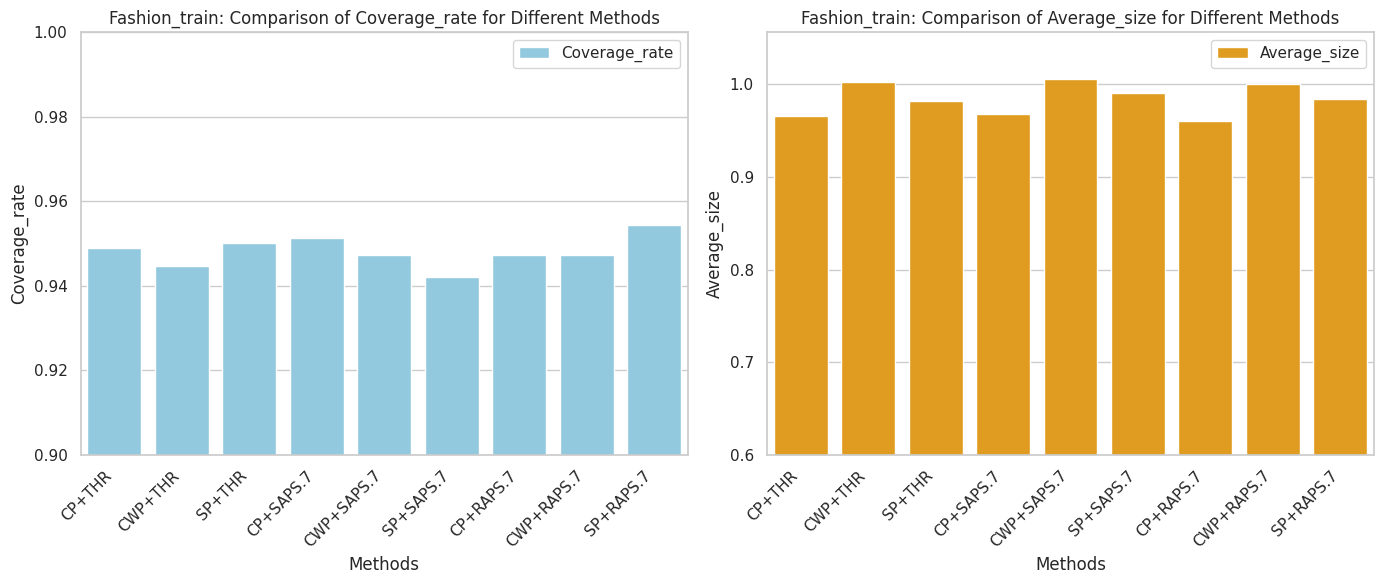

In [15]:
sns.set_theme()
sns.set(style="whitegrid", palette="deep")

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.barplot(x=setting, y=Coverage_rates,  color='skyblue', label='Coverage_rate')

plt.xlabel('Methods')
plt.ylabel('Coverage_rate')
plt.title('Fashion_train: Comparison of Coverage_rate for Different Methods')
plt.xticks(rotation=45, ha='right')
plt.ylim(0.9,1)
plt.legend()

plt.subplot(1, 2, 2)
sns.barplot(x=setting, y=Average_sizes,  color='orange', label='Average_size')
#sns.barplot(x='Model', y='Top-3 Accuracy', data=df, color='orange', label='Top-3 Accuracy')

plt.xlabel('Methods')
plt.ylabel('Average_size')
plt.title('Fashion_train: Comparison of Average_size for Different Methods')
plt.xticks(rotation=45, ha='right')
plt.ylim(0.6,)
plt.legend()

plt.tight_layout()
plt.show()